# How to Prove You’re Right: A/B Testing with SciPy
### by Hillary Green-Lerman, Lead Data Scientist, Looker
### Michoel Snow, Senior Data Scientist, Bark
### PyData NYC 2019

## What’s an A/B Test and why do I need it?

How might Amazon use an A/B Test?
- Test different price points for products
- Test different website designs
- Test different algorithms for displaying search results
- Test different algorithms for recommending additional items to purchase


How might Netflix use an A/B Test?
- Test different algorithms for recommending what to watch
- Test different website designs

How might _you_ use an A/B Test?

## What do I need to run an A/B Test?

Let's start by importing `pandas` (which we'll be using to load our datasets for this tutorial) and `matplotlib` (which we'll be using for graphing).

In [25]:
import pandas as pd

from matplotlib import pyplot as plt

### Example 1

You've sent out a newsletter to your users with an exciting new offer.  You're not sure what the best subject line is to get recipients to open the email and click through to your website, so you're running an A/B Test.  Your data is in the CSV file `ab_test_dataset_1.csv`.

- What kind of framework might you be using to run this test?

- What are some good metrics to track?

- Is anything missing from this dataset?

In [13]:
df1 = pd.read_csv('ab_test_dataset_1.csv')

df1.head()

# The dataset is missing whether or not the link was actually clicked

,id,first_name,last_name,email,gender,date,timestamp,ab_group
0,1,Brenn,Theze,btheze0@list-manage.com,Female,2019-07-09,11:23:49,A
1,2,Ludovico,Dinnage,ldinnage1@networkadvertising.org,Male,2019-05-27,8:56:10,A
2,3,Sherwood,Sitlinton,ssitlinton2@pagesperso-orange.fr,NaN,2019-02-28,8:53:02,B
3,4,Ariella,McAllan,a.mcallan@foobar.co.uk,Female,2019-07-14,23:19:36,B
4,5,Jeno,Methringham,jmethringham4@geocities.jp,Male,2019-08-15,10:29:18,A


### Example 2
You've just launched a new feature for your website.  You want to know what pop-up message is best to prompt people to use this feature, so you're running an A/B Test.  Your data is in the CSV file `ab_test_dataset_2.csv`.

- What kind of framework might you be using to run this test?

- What are some good metrics to track?

- Is anything missing from this dataset?

In [14]:
df2 = pd.read_csv('ab_test_dataset_2.csv')

df2.head()

,id,username,city,date,timestamp,test_ab,uses_feature
0,1,dbernasek0,Ganquan,2019-03-29,9:03:24,A,True
1,2,gbarson1,Qandala,2019-06-28,20:18:43,A,True
2,3,dayree2,Espinal,2019-09-07,10:07:15,A,True
3,4,fitzcak3,Jocón,2019-04-17,20:43:42,A,True
4,5,rkelcey4,Kímolos,2019-10-08,15:08:38,A,False


In [15]:
df2.groupby('test_ab').id.count()

test_ab
A    1000
Name: id, dtype: int64

It looks like we forgot to include the B Variant!

### Example 3
You're considering changing the price of your product.  In order to test how price point affects purchase rates, you randomly send out different discount codes to users for either 5%, 10%, or 20% off of your base price.  Your data is in the CSV file `ab_test_dataset_3.csv`.

- What kind of framework might you be using to run this test?

- What are some good metrics to track?

- Is anything missing from this dataset?

- **Bonus 1:** Why might discount codes not give you a good sense of purchase rates for different price points?

- **Bonus 2:** If the purchase rate at a 5% discount is 0.02 and the purchase rate at a 20% discount is 0.021, should you sent your price point to 20% off of your current base price? *(assume that the difference is significant)*

In [16]:
df3 = pd.read_csv('ab_test_dataset_3.csv')

df3.head()

,ip_address,date,timestamp,discount_amount,is_purchase
0,58.171.165.83,2019-09-08,16:19:16,20%,False
1,241.202.36.52,2019-07-10,4:09:29,10%,True
2,231.85.247.31,2019-08-21,0:45:36,10%,False
3,70.79.47.158,2019-08-30,3:28:50,20%,False
4,107.239.177.198,2019-01-26,14:37:03,20%,True


In [19]:
df3.groupby('ip_address').discount_amount.nunique()\
    .reset_index().head()

,ip_address,discount_amount
0,0.97.255.219,2
1,1.149.48.104,2
2,10.148.89.73,1
3,100.65.221.215,2
4,101.186.199.43,2


It looks like the same IP Address can see multiple discount ammounts.  This could upset customers if not conducted carefully!

#### Bonus 1: Why might discount codes not give you a good sense of purchase rates for different price points?
The greater the discount amount, the more that the customer feels that she got a "good deal".  If the price was just lower without being told that there was a discount, customers might not feel as "good" about it.


#### Bonus 2: If the purchase rate at a 5% discount is 0.02 and the purchase rate at a 20% discount is 0.021, should you sent your price point to 20% off of your current base price? *(assume that the difference is significant)*
In this case, you actually care about the total amount of money, not the purchase rate.  Imagine that 1000 customers visit your website and your product costs $100.

In [21]:
# For a 5% discount the product costs $95 and 2% of the 1000 customers will buy it
profit_5percent_discount = 1000 * 0.02 * 95
profit_5percent_discount

1900.0

In [22]:
# For a 20% discount the product costs $80 and 2.1% of the 1000 customers will buy it
profit_20percent_discount = 1000 * 0.021 * 80
profit_20percent_discount

1680.0

Even though more people purchased at a 20% discount, you made less money, so you probably don't want to go with that variant.

## How do I analyze an A/B Test?

### Example 4
Let's prove to ourselves that A/B Test results can be deceiving!

We're going to generate some results drawn from real distributions and see how effect size and sample size affect our ability to get reliable results.

We'll use a seperate `np.random.binomial()` to generate the samples for each variant.  This function takes as arguments:
- The number of samples in each experiment (i.e., how many people would see a given variant of your A/B Test)
- The probability of a success (i.e., the click-through rate for one of your variants)
- The number of experiments to run (we choose a large number so that we can get a reliable estimate)

In [23]:
import numpy as np

def calc_percent_correct(sample_size, ctr_A, ctr_B, number_experiments):
    '''
    This function performs a set of mock A/B Tests for two click through rates
    and a given sample size and reports the fraction of experiments where the
    directionality of the result is correct.
    
    You can use this function to see how often we would actually
    observe the "correct" results for given conditions.
    '''
    # Create experiments
    experimental_ctr_A = np.random.binomial(sample_size, ctr_A, size=number_experiments) / sample_size
    experimental_ctr_B = np.random.binomial(sample_size, ctr_B, size=number_experiments) / sample_size

    # Calculate the fraction of experiments with "correct" results
    if ctr_A < ctr_B:
        return np.mean(experimental_ctr_A < experimental_ctr_B)
    elif ctr_A > str_b:
        return np.mean(experimental_ctr_A > experimental_ctr_B)
    else:
        return np.mean(experimental_ctr_A == experimental_ctr_B)


Use the function with different values of `ctr_A`, `ctr_B`, and `sample_size`.  How do these affect the fraction of experiments with correct directionality?

In [24]:
# The parameters for our experiment
sample_size = 100
ctr_A = 0.05
ctr_B = 0.06
number_experiments = 10000

# How often is the CTR for B greater than for A?
fraction_correct = calc_percent_correct(sample_size, ctr_A, ctr_B, number_experiments)
print("Click through rates are directionally correct in %0.2f fraction of experiments." %fraction_correct)

Click through rates are directionally correct in 0.57 fraction of experiments.


Let's create a plot of how sample size effects the fraction of experiments with the correct results.

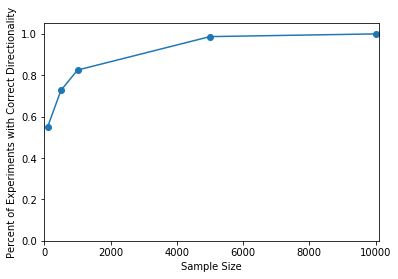

In [7]:
ctr_A = 0.05
ctr_B = 0.06
number_experiments = 10000

sample_sizes = [100, 500, 1000, 5000, 10000]
fraction_correct = [calc_percent_correct(sample_size, ctr_A, ctr_B, number_experiments)
                   for sample_size in sample_sizes]

plt.plot(sample_sizes, fraction_correct, '-o')
plt.xlabel('Sample Size')
plt.ylabel('Percent of Experiments with Correct Directionality')
plt.axis([-10, 10100, 0, 1.05])
plt.show()

Now let's see how the difference between the two click through rates affects the fraction of experiments with correct results.

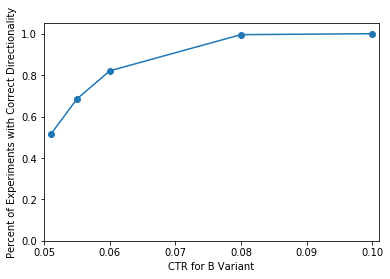

In [8]:
ctr_A = 0.05
sample_size = 1000
number_experiments = 10000

ctr_B_list = [0.051, 0.055, 0.06, 0.08, 0.10]
fraction_correct = [calc_percent_correct(sample_size, ctr_A, ctr_B, number_experiments)
                   for ctr_B in ctr_B_list]

plt.plot(ctr_B_list, fraction_correct, '-o')
plt.xlabel('CTR for B Variant')
plt.ylabel('Percent of Experiments with Correct Directionality')
plt.axis([0.05, 0.101, 0, 1.05])
plt.show()

What if we have much higher click through rates, but always keep the same **relative** difference (10% lift)?

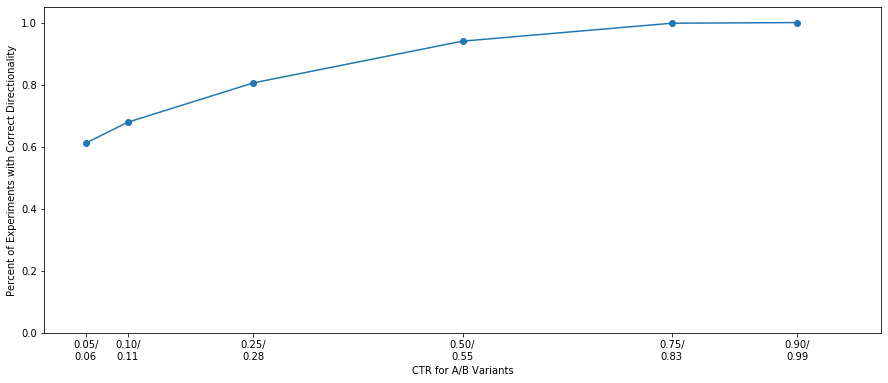

In [9]:
sample_size = 500
number_experiments = 10000

ctr_A_list = [0.05, 0.10, 0.25, 0.5, 0.75, 0.9]
fraction_correct = [calc_percent_correct(sample_size, ctr_A, 1.1* ctr_A, number_experiments)
                   for ctr_A in ctr_A_list]

plt.figure(figsize=(15, 6))
ax = plt.subplot()
plt.plot(ctr_A_list, fraction_correct, '-o')
ax.set_xticks(ctr_A_list)
ax.set_xticklabels(['%0.2f/\n%0.2f' %(ctr_A, 1.1 * ctr_A) for ctr_A in ctr_A_list])
plt.xlabel('CTR for A/B Variants')
plt.ylabel('Percent of Experiments with Correct Directionality')
plt.axis([0.0, 1, 0, 1.05])
plt.show()

### Example 5

Let's analyze the results of a simple A/B test of two different ads.  We create a **contingency table** with the number of users who fall into each category.

<table>
    <tr>
        <td></td>
        <th>A</th>
        <th>B</th>
    </tr>
    <tr>
        <th>Did Not Click Ad</th>
        <td>950</td>
        <td>940</td>
    </tr>
    <tr>
        <th>Clicked Ad</th>
        <td>50</td>
        <td>60</td>
    </tr>    
</table>

In [10]:
from scipy.stats import chi2_contingency

contingency = np.array([
    [950, 940],
    [50,  60]
])

g, pvalue, dof, expctd = chi2_contingency(contingency, correction=False)

print('P-value: %0.4f' %pvalue)

P-value: 0.3267


What if the proportions were the same but the sample size was 5 times as large?

In [11]:
contingency = 5 * np.array([
    [950, 940],
    [50,  60]
])

g, pvalue, dof, expctd = chi2_contingency(contingency, correction=False)

print('P-value: %0.4f' %pvalue)

P-value: 0.0283


It's worth noting that when we only have two variants, we could also use a Proportion Z-Test and get the same answers

In [12]:
from statsmodels.stats.proportion import proportions_ztest

contingency = 5 * np.array([
    [950, 940],
    [50,  60]
])

zscore, pvalue = proportions_ztest(contingency[1, :], contingency.sum(axis=0), alternative='two-sided')
print('P-value: %0.4f' %pvalue)

P-value: 0.0283
